<a href="https://colab.research.google.com/github/lamd91/VAE_DA/blob/master/VAE_SinuousChannelsImages_TPUStrategy_(3)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from IPython import display
import os
import pickle
import random
import shutil
from PIL import Image
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set up TPUs and initialize TPU strategy

In [2]:
try:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    print('Number of accelerators: ', strategy.num_replicas_in_sync)
except ValueError:
    print("TPU failed to initialize.")

INFO:tensorflow:Initializing the TPU system: grpc://10.0.27.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.27.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.0.27.106:8470']
Number of accelerators:  8


# Download the Dataset

Upload on Google Drive `mps_simulations.tar.gz` and `strebelle2500.png` located in the "data" directory of the github repository. 
Extract the content of `mps_simulations.tar.gz` here in Colab. The extracted files will be located in a directory named `images`.

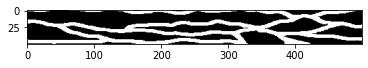

In [ ]:
!tar -xf "/content/gdrive/My Drive/mps_simulations.tar.gz" 
!rm -r images/.ipynb_checkpoints

# Show one example of MPS simulation image that could be used for training
i = random.randint(0, 1999)
image = pickle.load(open(f'images/img-{i}.pickle', 'rb')).astype('uint8')
plt.imshow(image, cmap='gray')

Copy the file `strebelle2500.png` in Colab. It will be used to prepare additional image data for training and validation.

'/content/gdrive/MyDrive/strebelle2500.png' -> './strebelle2500.png'


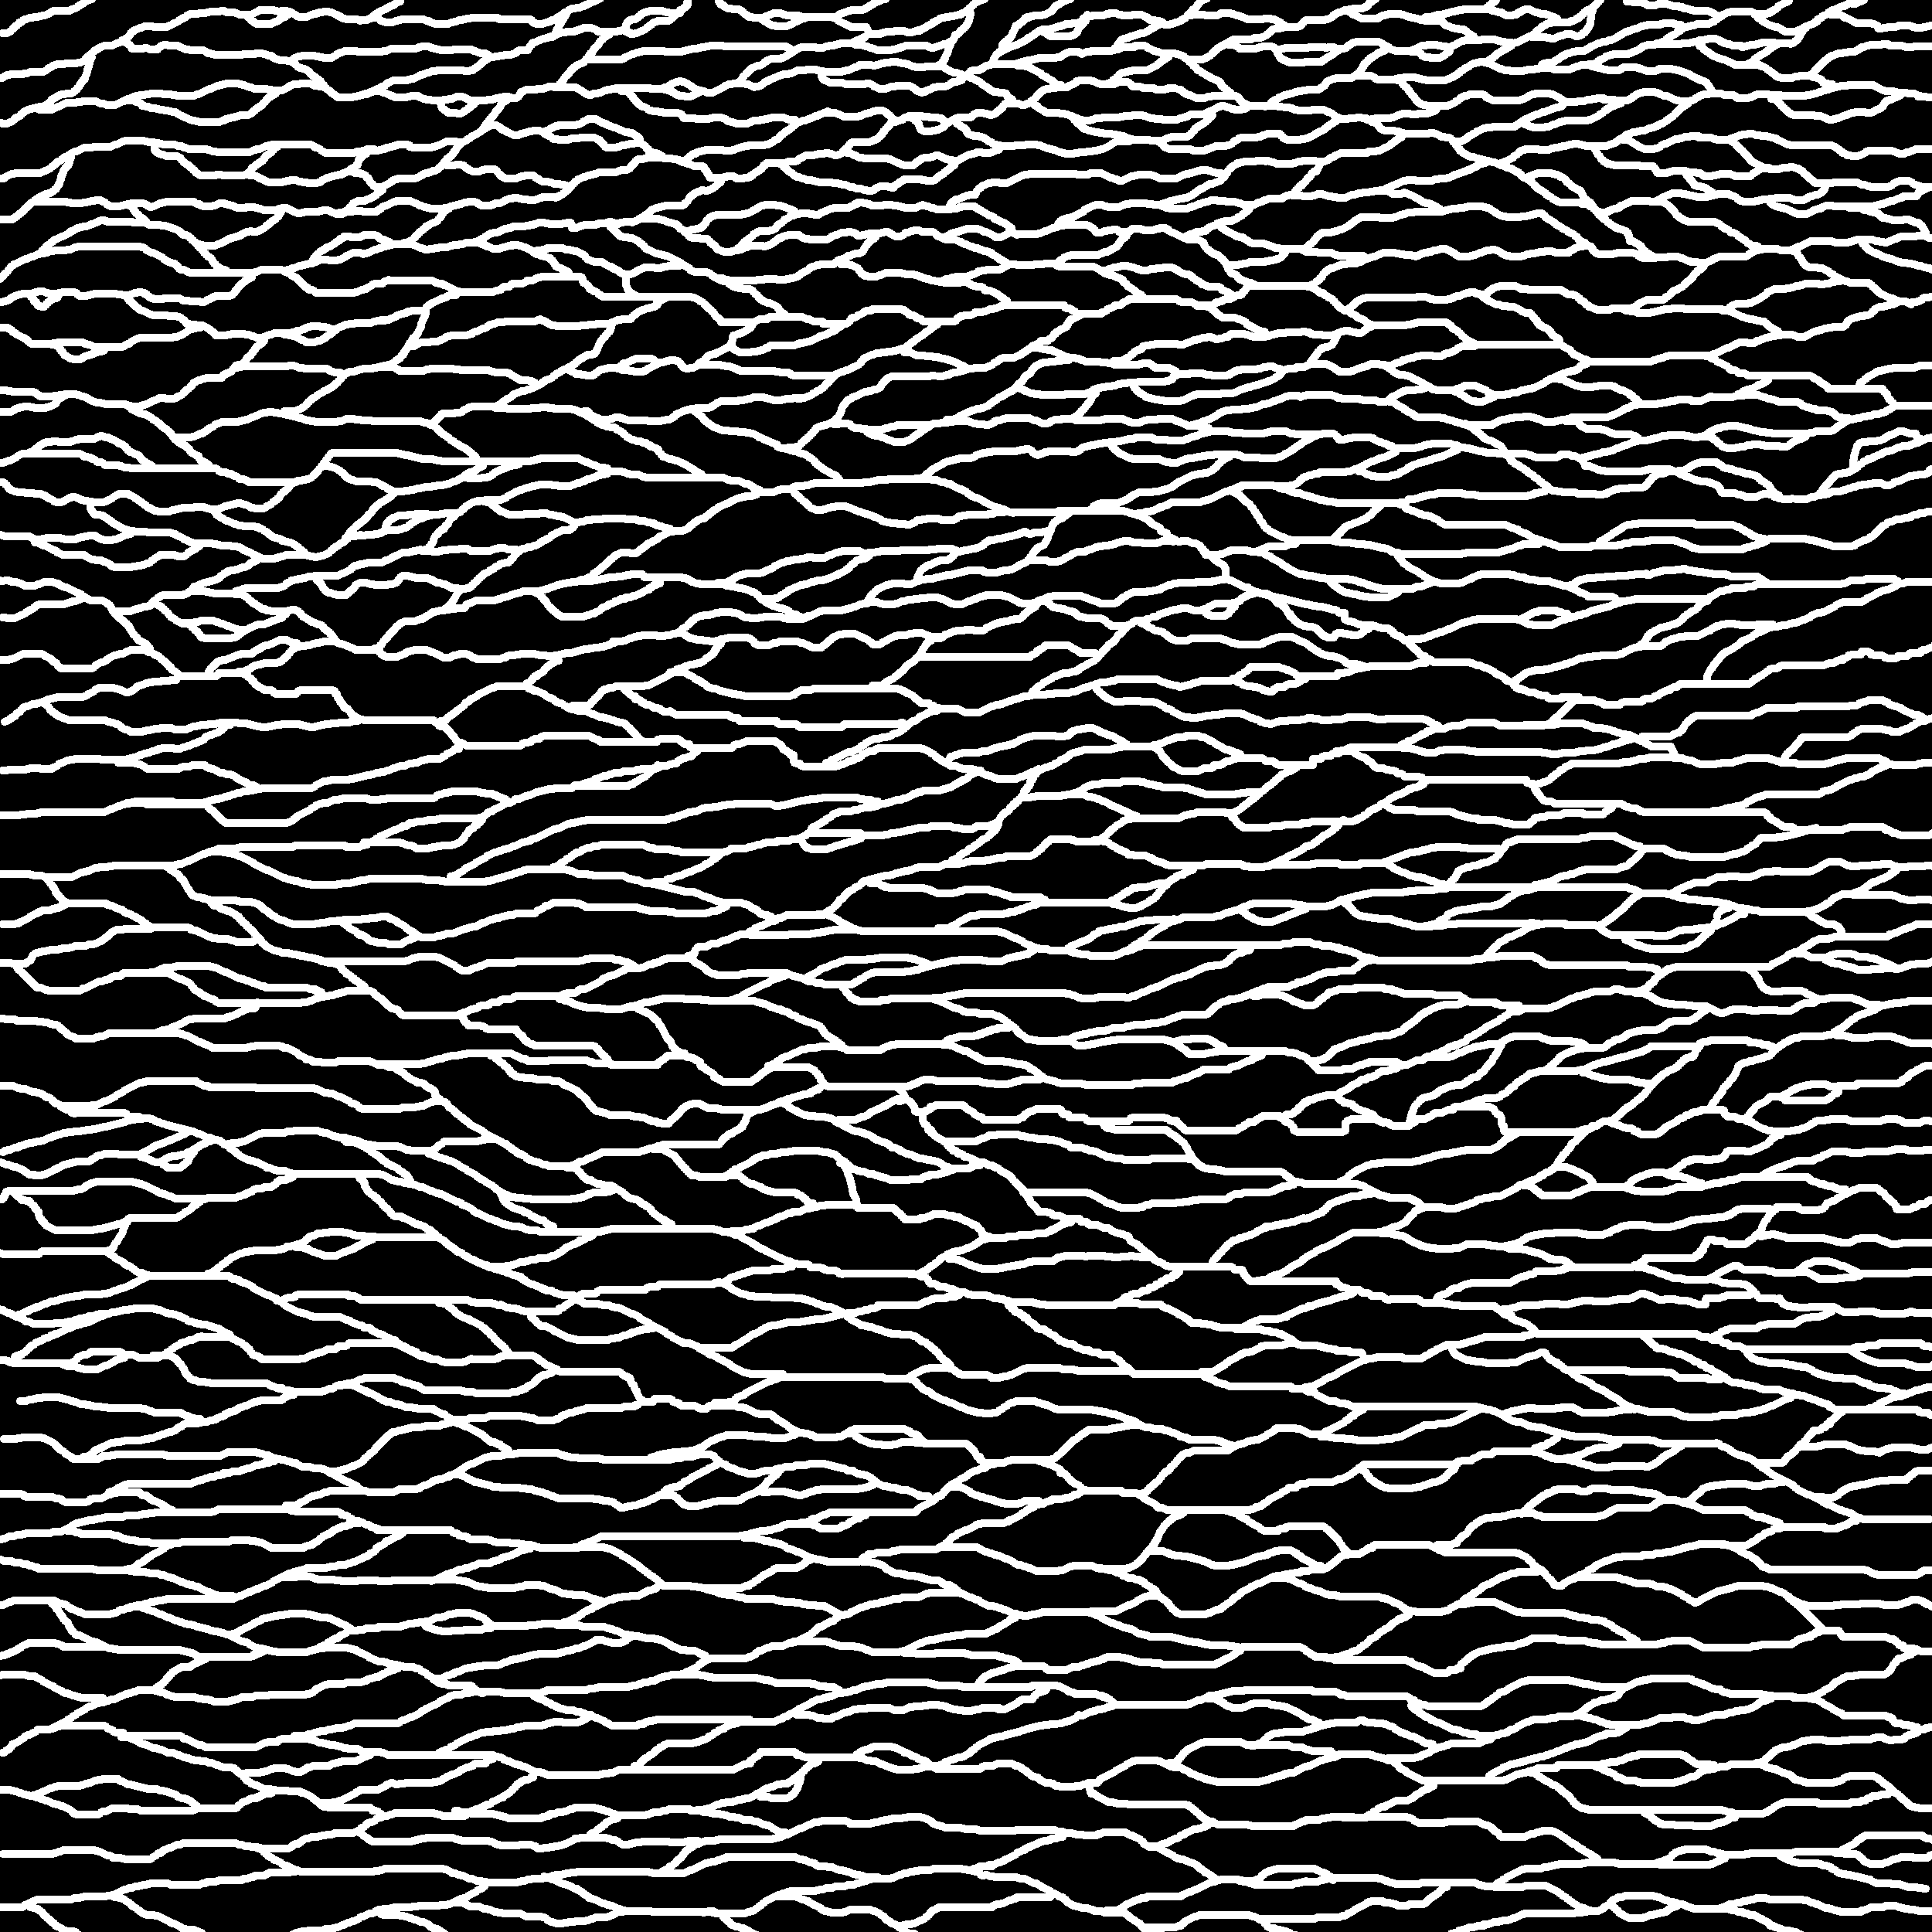

In [3]:
!cp -v /content/gdrive/MyDrive/strebelle2500.png .

# Show image
im = Image.open('strebelle2500.png')
im

In [4]:
# Define global constants
BATCH_SIZE_PER_REPLICA = 128
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
LATENT_DIM = 256
EPOCHS = 500
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 500
NUM_CHANNELS = 1
NUM_EXAMPLES = 40000
TEST_SIZE = 0.25

# Prepare the Dataset

In [6]:
def map_reshape_label(image):
    '''Returns a reshaped tensor from a given image as image and label'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.expand_dims(image, -1)

    return image, image

def map_flip_label(image, flip_type):
    """Returns a reshaped and flipped image (upside down or left to right) 
    as image and label"""
    image = tf.cast(image, dtype=tf.float32)
    image = tf.expand_dims(image, -1)
    if flip_type == "vertical":
        image = tf.image.flip_up_down(image)  
    elif flip_type == "horizontal":
        image = tf.image.flip_left_right(image)

    return image, image

In [ ]:
def split_and_augment_data_type1(test_size):
    """Split MPS images (type 1) into training and testing datasets"""

    image_filenames = sorted(os.listdir('images')) # directory containing the images generated by MPS simulations
    num_examples = len(image_filenames)
    num_training_examples = int(num_examples * (1 - test_size))

    images = []
    for image_filename in image_filenames:
        src = os.path.join('images', image_filename)
        image = pickle.load(open(src, 'rb'))
        images.append(image)

    train_dataset = tf.data.Dataset.from_tensor_slices(images[0:num_training_examples])
    val_dataset = tf.data.Dataset.from_tensor_slices(images[num_training_examples:])

    train_dataset_2 = train_dataset.map(map_reshape_label).cache().shuffle(1024).batch(BATCH_SIZE, drop_remainder=True)

    train_dataset_orig = train_dataset.map(map_reshape_label)
    val_dataset = val_dataset.map(map_reshape_label).cache().batch(BATCH_SIZE, drop_remainder=True)

    train_dataset_flipped_up_down = train_dataset.map(lambda x: map_flip_label(x, "vertical"))
    train_dataset_flipped_left_right = train_dataset.map(lambda x: map_flip_label(x, "horizontal"))
    train_dataset = train_dataset_orig.concatenate(train_dataset_flipped_up_down).concatenate(train_dataset_flipped_left_right).cache().shuffle(1024).batch(BATCH_SIZE, drop_remainder=True)

    print("Number of MPS image examples for training:", num_training_examples)
    print("Number of MPS image examples for validation:", num_examples - num_training_examples)

    return train_dataset, val_dataset
    #return train_dataset_2, val_dataset

train_dataset, val_dataset = split_and_augment_data_type1(0.3)

In [7]:
def map_image(image):
    '''returns a reshaped tensor from a given image'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.expand_dims(image, -1)

    return image, image

def map_rescale_reshape_flip_label(image, flip_type):
    """Returns a reshaped and flipped image (upside down or left to right) 
    as image and label"""
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.expand_dims(image, -1)
    if flip_type == "vertical":
        image = tf.image.flip_up_down(image)  
    elif flip_type == "horizontal":
        image = tf.image.flip_left_right(image)

    return image, image

def extract_subimages_from_image(image_file, num_subimages):
    """Extract random images of fixed size from a given big image."""
    # First resize original image
    im = Image.open(image_file)
    im_resized = im.resize((im.size[0], int(im.size[1]*0.5)))

    # Then extract subimages from the resized image
    subimages = []
    x_y_pairs = set()
    count = 0
    while count < num_subimages:
        x_topleft = np.random.randint(0, 2000)
        y_topleft = np.random.randint(0, 1200)
        if (x_topleft, y_topleft) not in x_y_pairs:
            im_crop = im_resized.crop((x_topleft, 
                                       y_topleft, 
                                       x_topleft + IMAGE_WIDTH, 
                                       y_topleft + IMAGE_HEIGHT))
            im_final = np.array(im_crop, dtype=np.uint8)
            subimages.append(im_final)
            for i in range(5):
                x_y_pairs.add((x_topleft+i, y_topleft+i))
            count += 1

    return subimages

def get_datasets(images, test_size):
    """Prepares the datasets from list of images."""
    train_dataset = tf.data.Dataset.from_tensor_slices(
        images[0:int(NUM_EXAMPLES*(1-test_size))])
    val_dataset = tf.data.Dataset.from_tensor_slices(
        images[int(NUM_EXAMPLES*(1-test_size)):])

    train_dataset_2 = train_dataset.map(map_image).cache().shuffle(1024).batch(BATCH_SIZE, drop_remainder=True)
    
    train_dataset_orig = train_dataset.map(map_image)
    train_dataset_flipped_up_down = train_dataset.map(lambda x: map_rescale_reshape_flip_label(x, "vertical"))
    train_dataset_flipped_left_right = train_dataset.map(lambda x: map_rescale_reshape_flip_label(x, "horizontal"))
    train_dataset = train_dataset_orig.concatenate(train_dataset_flipped_up_down).concatenate(train_dataset_flipped_left_right).cache().shuffle(1024).batch(BATCH_SIZE, drop_remainder=True)

    val_dataset = val_dataset.map(map_image).cache().batch(BATCH_SIZE, drop_remainder=True)

    #return train_dataset_2, val_dataset
    return train_dataset, val_dataset

# Load and prepare image dataset for training
image_array = extract_subimages_from_image("strebelle2500.png", NUM_EXAMPLES)
with open('subimages.pkl', 'wb') as f:
    pickle.dump(image_array, f)
train_dataset, val_dataset = get_datasets(image_array, test_size=TEST_SIZE)

In [ ]:
from google.colab import files 
files.download('subimages.pkl')

In [ ]:
# Load and prepare image dataset for training using already extracted subimages
image_array = pickle.load(open('subimages.pkl', 'rb'))
train_dataset, val_dataset = get_datasets(image_array, map_image,
                                                        test_size=TEST_SIZE)

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """Generates a random sample and combines with the encoder output

        Args:
          inputs -- output tensor from the encoder

        Returns:
          `inputs` tensors combined with a random sample
        """

        # unpack the output of the encoder
        mu, sigma = inputs

        # get the size and dimensions of the batch
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # generate a random tensor
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # combine the inputs and noise
        return mu + tf.exp(0.5 * sigma) * epsilon

def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space

    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_2.shape -- shape of the features before flattening
    """

    # add the Conv2D layers followed by BatchNormalization
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation='relu',
                               name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu',
                               name="encode_conv2")(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu',
    #                            name="encode_conv3")(x)

    # assign to a different variable so you can extract the shape later
    batch_3 = tf.keras.layers.BatchNormalization()(x)

    # flatten the features and feed into the Dense network
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)

    # we arbitrarily used ... units here but feel free to change
    x = tf.keras.layers.Dense(512, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

    return mu, sigma, batch_3.shape

def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening
    """

    # declare the inputs tensor with the given shape
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get the output of the encoder_layers() function
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # build the whole encoder model
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

    return model, conv_shape

# Define decision variables for adding a Cropping2D layer or not after 
# upsampling in decoder layers
topcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_HEIGHT/2)/2) % 2 != 0)
leftcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_WIDTH/2)/2) % 2 != 0)
topcrop_after_upsampling2 = (math.ceil(IMAGE_HEIGHT/2) % 2 != 0)
leftcrop_after_upsampling2 = (math.ceil(IMAGE_WIDTH/2) % 2 != 0)
topcrop_after_upsampling3 = (IMAGE_HEIGHT % 2 != 0)
leftcrop_after_upsampling3 = (IMAGE_WIDTH % 2 != 0)

def decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                   leftcrop_after_upsampling1, topcrop_after_upsampling2, 
                   leftcrop_after_upsampling2,
                   topcrop_after_upsampling3, leftcrop_after_upsampling3):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder
      conv_shape -- shape of the features before flattening

    Returns:
      tensor containing the decoded output
    """

    # feed to a Dense network with units computed from the conv_shape dimensions
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, 
                              activation='relu', 
                              name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # reshape output using the conv_shape dimensions
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), 
                                name="decode_reshape")(x)

    # upsample the features back to the original dimensions
    # for that, make sure to add Cropping2D layers after upsampling when needed
    # x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
    #                                     padding='same', activation='relu',
    #                                     name="decode_conv2d_1")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # if topcrop_after_upsampling1:
    #     x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    # if leftcrop_after_upsampling1:
    #     x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                        padding='same', activation='sigmoid',
                                        name="decode_final")(x)

    return x

def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening

    Returns:
      model -- the decoder model
    """

    # set the inputs to the shape of the latent space
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # get the output of the decoder layers
    outputs = decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                             leftcrop_after_upsampling1, 
                             topcrop_after_upsampling2, 
                             leftcrop_after_upsampling2, 
                             topcrop_after_upsampling3, 
                             leftcrop_after_upsampling3)

    # declare the inputs and outputs of the model
    model = tf.keras.Model(inputs, outputs)

    return model

def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation

    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch

    Returns:
      the complete VAE model
    """
    # set the inputs
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get mu, sigma, and z from the encoder output
    mu, sigma, z = encoder(inputs)

    # get reconstructed output from the decoder
    reconstructed = decoder(z)

    # define the inputs and outputs of the VAE
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

    # add the KL loss
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)

    return model

def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, 
                                        input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae


# Define a VAE class via model subclassing
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, variational_autoencoder, loss_metrics,
                 val_loss_metrics):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vae = variational_autoencoder
        self.loss_metrics = loss_metrics
        self.val_loss_metrics = val_loss_metrics

    # override train_step method
    def train_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        with tf.GradientTape() as tape:
            # feed a batch to the VAE model
            reconstructed = self.vae(images)
            # compute reconstruction loss
            flattened_inputs = tf.reshape(images, [-1])
            flattened_outputs = tf.reshape(reconstructed, [-1])
            loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
                   * images.shape[1] * images.shape[2]
            # add KLD regularization loss
            loss += sum(self.vae.losses)

        # compute the gradients and update the model weights
        grads = tape.gradient(loss, self.vae.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.vae.trainable_weights))

        # update metrics
        self.loss_metrics.update_state(loss)
        
        # return a dict mapping metrics names to current value
        return {'loss': self.loss_metrics.result()}

    # override test_step method
    def test_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        # compute predictions
        reconstructed = self.vae(images)
        # compute loss
        flattened_inputs = tf.reshape(images, [-1])
        flattened_outputs = tf.reshape(reconstructed, [-1])
        loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
               * images.shape[1] * images.shape[2]
        # add KLD regularization loss
        loss += sum(self.vae.losses)
        # update metrics
        self.val_loss_metrics.update_state(loss)
        # return a dict mapping metrics names to current value
        return {'loss': self.val_loss_metrics.result()}

    def call(self, images):
        if isinstance(images, tuple):
            images = images[0]
        return self.vae(images)

# Display Utilities

In [9]:
def generate_and_save_images(model, epoch, step, test_input, vae_model):
    """Helper function to plot our 8 images

    Args:

    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (8, LATENT_DIM)
    """

    # generate images from the test input
    predictions = model.predict(test_input)

    # plot the results
    fig = plt.figure(figsize=(12, 14))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 1, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

def show_loss_evolution(epoch, vae_model):
    """Display loss evolution during training of the VAE model"""
    
    if epoch != 0:
        fig = plt.figure()
        plt.scatter(range(len(vae_model.history.history['loss'])), 
                    vae_model.history.history['loss'])
        plt.scatter(range(len(vae_model.history.history['val_loss'])), 
                    vae_model.history.history['val_loss'], color='red')
        plt.savefig('Losses.png')
    plt.show()


def show_original_reconstructed_images(model, train_dataset):
    plt.figure(figsize=(10, 14))
    for input_images, _ in train_dataset.take(1):
        reconstructed = model(input_images)
        k = 0
        for i in range(5):
            #reconstructed_categorized = np.where(reconstructed >= 0.5, 1, 0)
            plt.subplot(5, 2, k+1)
            plt.imshow(np.squeeze(input_images[i]), cmap='gray')
            plt.subplot(5, 2, k+2)
            #plt.imshow(np.squeeze(reconstructed_categorized[i]), cmap='gray')
            plt.imshow(np.squeeze(reconstructed[i]), cmap='gray')
            k += 2
        plt.savefig("reconstructed_images.png")
    plt.show()

# Select the learning rate parameter for training

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create callback for adjusting learning rate during training
# The learning rates will vary from 1e-6 to 0.01 over 100 epochs
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

with strategy.scope():
    # Get the encoder, decoder and 'master' model (called vae)
    encoder, decoder, var_autoencoder = get_models(
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
        latent_dim=LATENT_DIM)

    # Instantiate VAE class
    loss_metrics = tf.keras.metrics.Mean()
    val_loss_metrics = tf.keras.metrics.Mean()
    vae = VAE(encoder, decoder, var_autoencoder, loss_metrics, val_loss_metrics)

    # Compile model
    vae.compile(
        optimizer = tf.keras.optimizers.Adam(lr=1e-6),
        loss = tf.keras.losses.BinaryCrossentrpy()
    )

# Training loop using original dataset
history = vae.fit(train_dataset, epochs=100, verbose=1, callbacks=[lr_schedule])

In [ ]:
# Plot losses against learning rates
plt.semilogx(vae.history.history['lr'], vae.history.history['loss'])
plt.axis([1e-6, 0.01, 1700, 2300])

# Train the model


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create a callback that saves locally the model's weights every few epochs of
# training
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './cp-cp{epoch:04d}.ckpt',
    options = save_locally,
    verbose = 1,
    save_freq = math.ceil(NUM_EXAMPLES*(1-TEST_SIZE)/BATCH_SIZE) * 20
)

# Create custom callback to display outputs (via helper function) at the end of 
# each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Plot loss 
        show_loss_evolution(epoch, vae)
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))
        display.clear_output(wait=True)
        if epoch % 20 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(NUM_EXAMPLES/BATCH_SIZE), 
                                     random_vector_for_generation, vae)
with strategy.scope():
    # Get the encoder, decoder and 'master' model (called vae)
    encoder, decoder, var_autoencoder = get_models(
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
        latent_dim=LATENT_DIM)

    # Instantiate VAE class
    loss_metrics = tf.keras.metrics.Mean()
    val_loss_metrics = tf.keras.metrics.Mean()
    vae = VAE(encoder, decoder, var_autoencoder, loss_metrics, val_loss_metrics)

    # Compile model
    vae.compile(
        optimizer = tf.keras.optimizers.Adam(lr=3e-4),
        loss = tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM
        )
        )

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation, vae)

# Training loop using original dataset
history = vae.fit(x=train_dataset, epochs=EPOCHS, verbose=1, 
                  validation_data = val_dataset, 
                  callbacks=[cp_callback, CustomCallback()])     

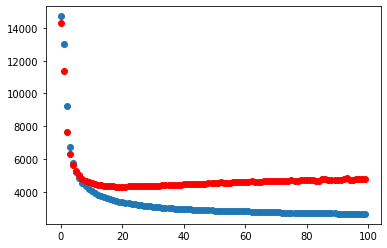

In [16]:
# Track loss evolution on the training/validation sets over epochs
plt.scatter(range(len(vae.history.history['loss'])), vae.history.history['loss'])
plt.scatter(range(len(vae.history.history['loss'])), vae.history.history['val_loss'], color='red')

# Resume training if necessary

In [11]:
with strategy.scope():

    # Get the encoder, decoder and 'master' model (called vae)
    encoder, decoder, var_autoencoder = get_models(
       input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
       latent_dim=LATENT_DIM)

    # Create new instance of VAE class
    loss_metrics = tf.keras.metrics.Mean()
    val_loss_metrics = tf.keras.metrics.Mean()
    new_vae = VAE(encoder, decoder, var_autoencoder, loss_metrics,
              val_loss_metrics)

    # Load weights from last checkpoint saved
    checkpoint_dir = '.'
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print(latest)

    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    new_vae.load_weights(latest, options=load_locally)
    new_vae.compile(
        optimizer = tf.keras.optimizers.Adam(3e-4),
        loss = tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.SUM
        )
    )

./cp-cp0097.ckpt


In [12]:
new_vae.evaluate(train_dataset, verbose=1)

87/87 [==============================] - 10s 55ms/step - loss: 2681.6087


2683.977783203125

In [ ]:
# Create a callback that saves the model's weights every few epochs during 
# training
checkpoint_path = './cp-cp{epoch:04d}.ckpt'
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    options = save_locally,
    verbose = 1,
    save_freq = math.ceil(NUM_EXAMPLES*(1-TEST_SIZE)/BATCH_SIZE) * 20
    )

# Create custom callback to display outputs (via helper function) at the end of 
# each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        display.clear_output(wait=True)
        if epoch % 20 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(NUM_EXAMPLES/BATCH_SIZE), 
                                     random_vector_for_generation, new_vae)
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))

# Resume training using original dataset
new_vae.fit(train_dataset, epochs=EPOCHS, verbose=1, 
            validation_data=val_dataset, 
            callbacks=[cp_callback, CustomCallback()])

In [ ]:
# Track loss evolution on the training/validation sets over epochs
plt.scatter(range(len(new_vae.history.history['loss'])), new_vae.history.history['loss'])
plt.scatter(range(len(new_vae.history.history['loss'])), new_vae.history.history['val_loss'], color='red')

# Plot reconstructed images

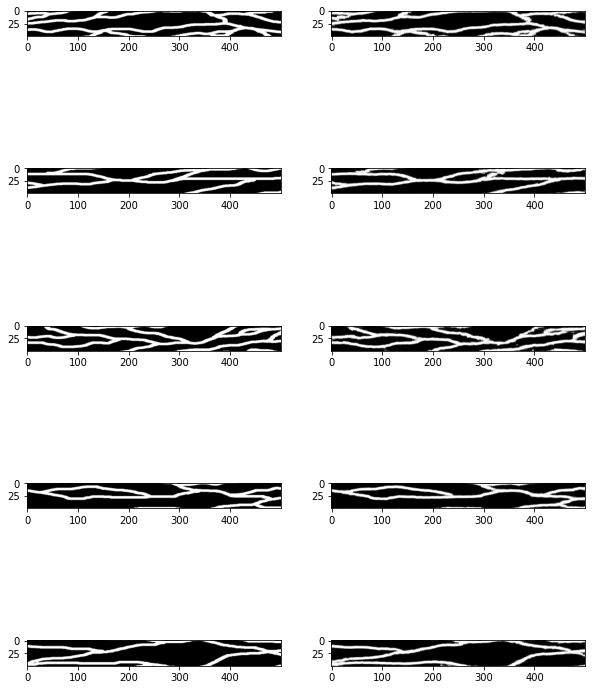

In [13]:
show_original_reconstructed_images(new_vae, train_dataset)

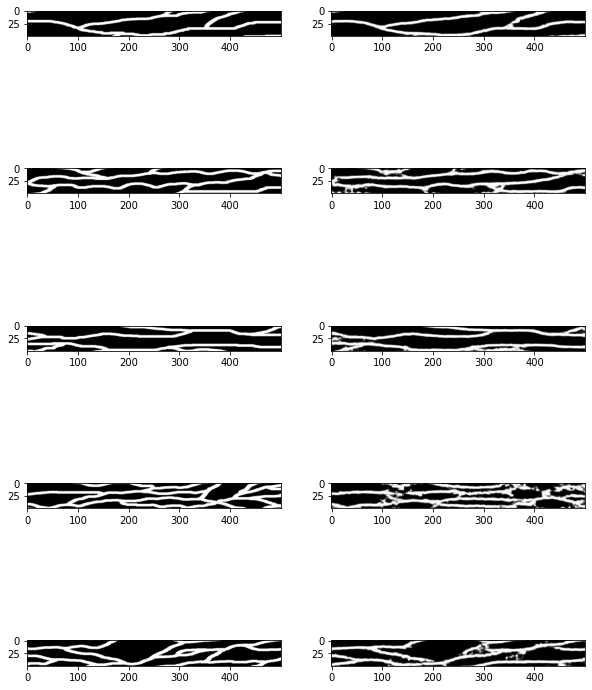

In [14]:
show_original_reconstructed_images(vae, val_dataset)

# Generate new images

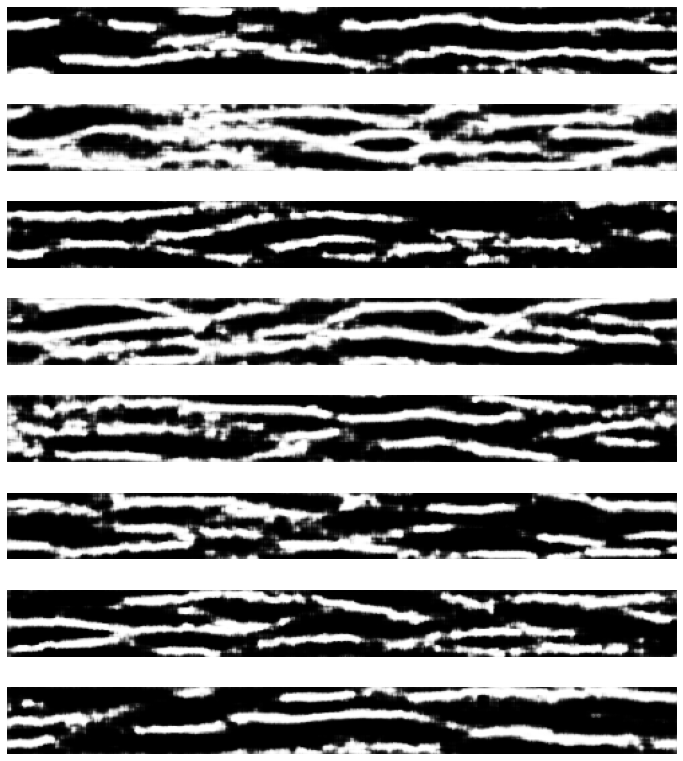

In [15]:
# Generate random vector as test input to the decoder
test_input = tf.random.normal(shape=[8, LATENT_DIM])

# Generate images from the test input
predictions = new_vae.decoder.predict(test_input)

# plot the results
fig = plt.figure(figsize=(12, 14))

for i in range(predictions.shape[0]):
    plt.subplot(8, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

In [ ]:
while True:
    pass